In [1]:
%matplotlib inline
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## 1 生成数据集

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1)) # 前面是train，后面是test
np.random.shuffle(features)
# ploy_feature[i] 就是 x^i / i!
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

## 2 定义、训练和测试模型

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.3073],
         [-1.3083]]),
 tensor([[ 1.0000e+00,  3.0726e-01,  4.7204e-02,  4.8347e-03,  3.7137e-04,
           2.2822e-05,  1.1687e-06,  5.1299e-08,  1.9703e-09,  6.7265e-11,
           2.0668e-12,  5.7731e-14,  1.4782e-15,  3.4938e-17,  7.6678e-19,
           1.5707e-20,  3.0163e-22,  5.4517e-24,  9.3060e-26,  1.5049e-27],
         [ 1.0000e+00, -1.3083e+00,  8.5587e-01, -3.7325e-01,  1.2208e-01,
          -3.1945e-02,  6.9658e-03, -1.3019e-03,  2.1292e-04, -3.0952e-05,
           4.0496e-06, -4.8166e-07,  5.2514e-08, -5.2850e-09,  4.9390e-10,
          -4.3079e-11,  3.5226e-12, -2.7110e-13,  1.9705e-14, -1.3569e-15]]),
 tensor([ 5.1885, -1.4078]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

## 3 三阶多项式函数拟合（正常）

weight: [[ 5.011886   1.1934434 -3.40903    5.6065836]]


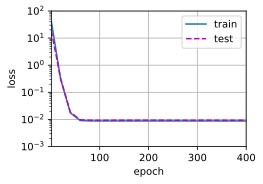

In [6]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

## 4 线性函数拟合（欠拟合）

weight: [[2.1182256 7.2296424]]


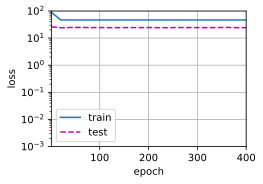

In [7]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

## 5 训练样本不足（过拟合）

weight: [[ 4.9938588e+00  1.2263603e+00 -3.3404040e+00  5.4698668e+00
  -1.9713894e-01  3.3256674e-01  3.1244031e-01 -5.0413531e-01
  -4.3954030e-02  1.2682847e-02  4.6615168e-02 -3.3962704e-02
  -2.6862420e-02 -6.8098947e-02 -9.9078156e-02  1.0945316e-01
  -9.3391966e-03  1.0930246e-01 -1.9714001e-01 -4.3091406e-03]]


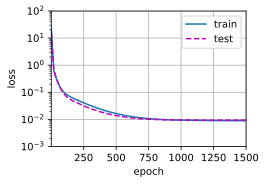

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)